Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V26       V27       V28  Class  \
0  0.098698  0.363787  0.090794  ... -0.189115  0.133558 -0.021053      0   
1  0.08510

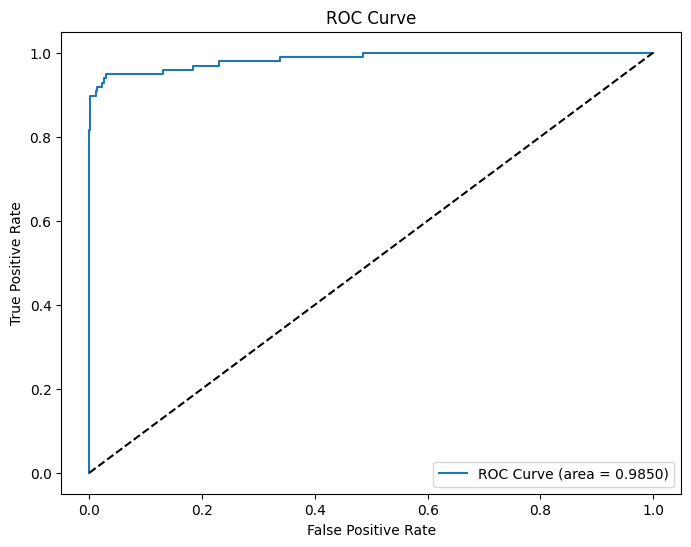

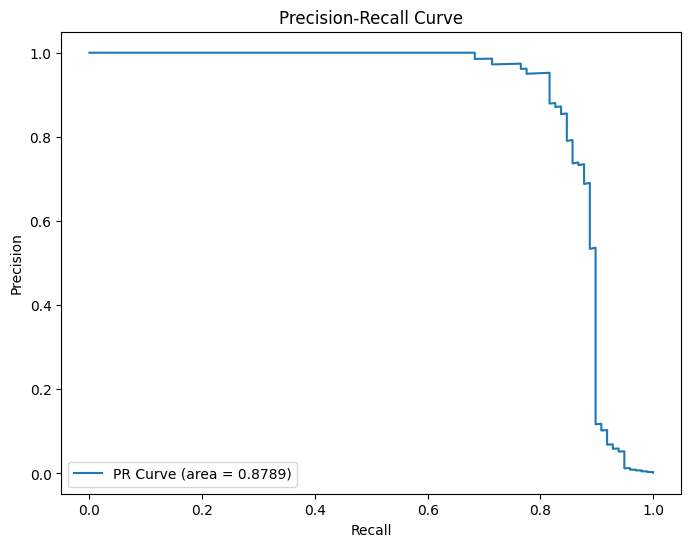

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


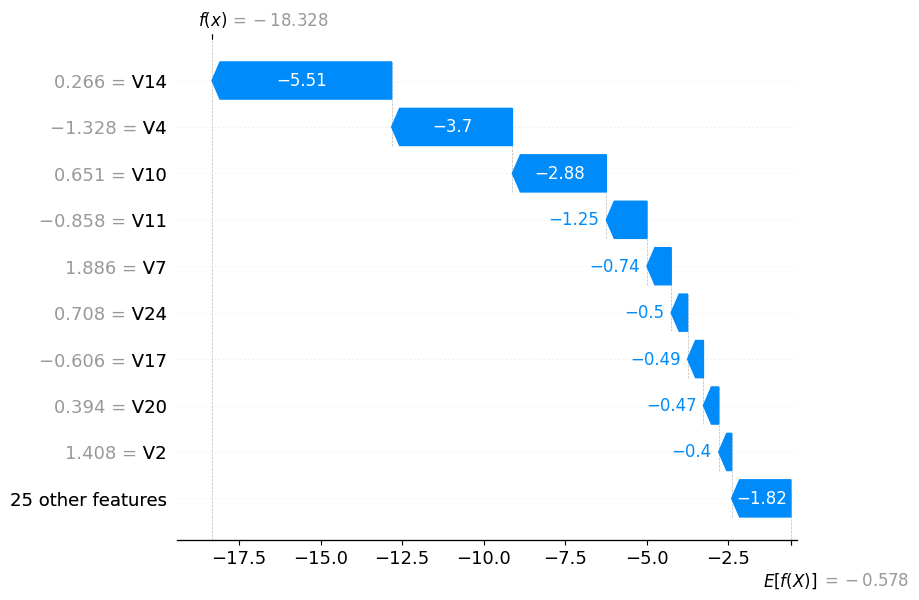

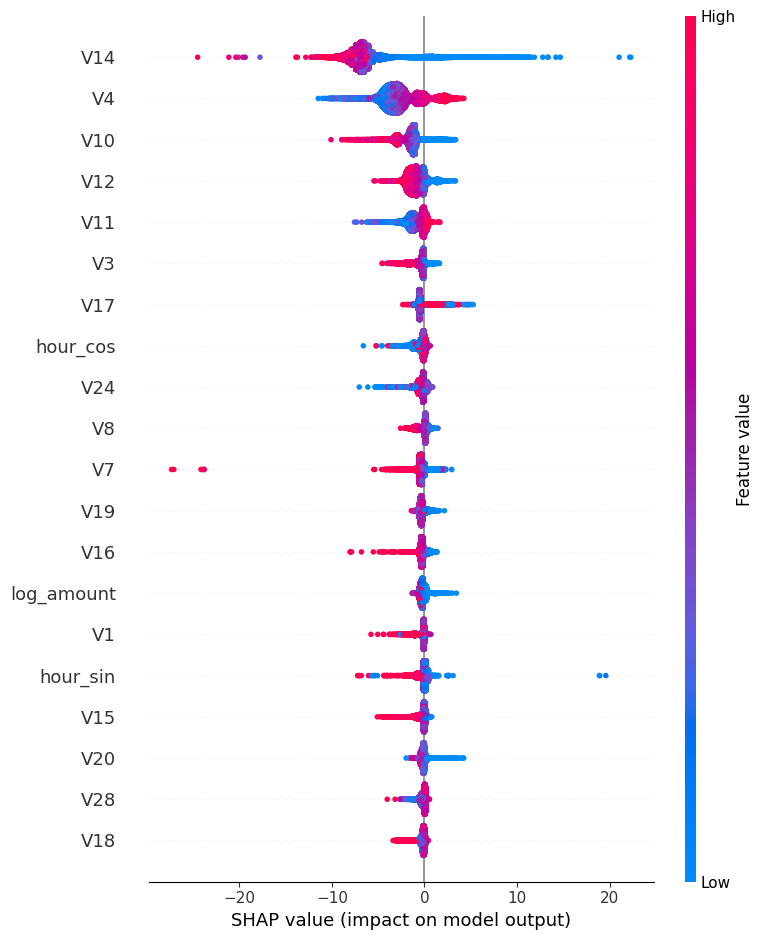


Transaction #56: Classified as NOT FRAUD
Model Confidence in fraud: 0.00%

Reasons for This Classification (Plain Language):
  1. V14: decreased impact by 24.64%.
  2. V4: decreased impact by 12.88%.
  3. V3: decreased impact by 9.74%.

Factors Contributing to the Decision (SHAP Values):
  - V14: decreased fraud likelihood by 24.64%
  - V4: decreased fraud likelihood by 12.88%
  - V3: decreased fraud likelihood by 9.74%


In [69]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, f1_score, accuracy_score,
    precision_score, recall_score)
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.preprocessing import RobustScaler
from collections import Counter
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss
from sklearn.ensemble import IsolationForest
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import OneClassSVM
import shap

# Load dataset
data = pd.read_csv("creditcard.csv")
# Check for NA values in each column
print(data.isnull().sum())

# # Scale 'Amount' and 'Time' features, then drop the originals
# data["scaled_amount"] = RobustScaler().fit_transform(data["Amount"].values.reshape(-1, 1))
# data["scaled_time"] = RobustScaler().fit_transform(data["Time"].values.reshape(-1, 1))
# data.drop(["Time", "Amount"], axis=1, inplace=True)

# Time-based features
data['hour'] = (data['Time'] % 86400) // 3600  # Extract hour
data['day'] = (data['Time'] // 86400) % 7  # Extract day

# Cyclic encoding for hour and day
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['day_sin'] = np.sin(2 * np.pi * data['day'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day'] / 7)
data.drop(['Time', 'hour', 'day'], axis=1, inplace=True)

data['scaled_amount'] = RobustScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data['amount_zscore'] = (data['scaled_amount'] - data['scaled_amount'].mean()) / data['scaled_amount'].std()
data['log_amount'] = np.log1p(data['scaled_amount'])
data.drop(['Amount', 'scaled_amount'], axis=1, inplace=True)

# #anomaly detection
# iso = IsolationForest(contamination=0.01, random_state=42)
# data['anomaly_score'] = iso.fit_predict(data[['V' + str(i) for i in range(1, 29)]])


#view data
print(data.head())


# Rearrange columns for better readability
cols = data.columns.tolist()
cols = [c for c in cols if c != "Class"] + ["Class"]
data = data[cols]

# Separate features and target
X = data.drop("Class", axis=1)
y = data["Class"]

#Imbalanced 

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# #Using Anomaly detection One class SVM
# X_majority = X_train[y_train == 0]
# oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
# oc_svm.fit(X_majority)
# y_ocsvm_pred = oc_svm.predict(X_train)  # +1 (normal), -1 (anomaly)
# y_ocsvm_binary = (y_ocsvm_pred == -1).astype(int)  # Convert to binary (1: anomaly, 0: normal)
# X_train_with_ocsvm = pd.DataFrame(X_train)
# X_train_with_ocsvm['ocsvm_pred'] = y_ocsvm_binary

# # Define SMOTE and NearMiss
# smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Oversample minority to 50% of the majority
# nearmiss = NearMiss(sampling_strategy=0.5)  # Undersample majority to match minority
# # Create pipeline
# pipeline = Pipeline([('smote', smote),('nearmiss', nearmiss)])
# X_res, y_res = pipeline.fit_resample(X_train, y_train)

# Appply Borderline SMOTE to the training data
sm = BorderlineSMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
# X_res, y_res = sm.fit_resample(X_train_with_ocsvm, y_train)

# # Apply SMOTE to the training data
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X_train, y_train)

# #Apply ADASYN to training data
# sm = ADASYN(random_state=42)
# X_res, y_res = sm.fit_resample(X_train, y_train)

# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # F1-Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1-Score: {f1:.4f}")

    # Precision and Recall
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # PR-AUC Score (Precision-Recall AUC)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    print(f"PR-AUC Score: {pr_auc:.4f}")

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label="ROC Curve (area = %0.4f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, label="PR Curve (area = %0.4f)" % pr_auc)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.show()

# # Logistic Regression (Balanced) model
# lr_balanced = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)
# lr_balanced.fit(X_train, y_train)
# print("Evaluating Logistic Regression with class_weight='balanced'")
# evaluate_model(lr_balanced, X_test, y_test)

# # Logistic Regression after SMOTE
# lr_smote = LogisticRegression(random_state=42, max_iter=1000)
# lr_smote.fit(X_res, y_res)
# print("Evaluating Logistic Regression after SMOTE")
# evaluate_model(lr_smote, X_test, y_test)

# # k-Nearest Neighbors (k-NN) model with SMOTE
# knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
# knn.fit(X_res, y_res)
# print("Evaluating k-Nearest Neighbors with SMOTE")
# evaluate_model(knn, X_test, y_test)

# Train LightGBM using LGBMClassifier
lgb_clf = LGBMClassifier(
    objective='binary',               # Binary classification
    boosting_type='gbdt',             # Gradient Boosting Decision Trees
    is_unbalance=True,                # Handle class imbalance
    learning_rate=0.1,                # Step size
    num_leaves=40,                    # Max leaves per tree
    max_depth=-1,                     # No limit on tree depth
    n_estimators=225,                 # Number of boosting rounds
    random_state=42
)

# # Step 1: Define base models (Level-0) for model stacking
# base_models = [
#     ('lightgbm', LGBMClassifier(
#     objective='binary',               # Binary classification
#     boosting_type='gbdt',             # Gradient Boosting Decision Trees
#     is_unbalance=True,                # Handle class imbalance
#     learning_rate=0.1,                # Step size
#     num_leaves=40,                    # Max leaves per tree
#     max_depth=-1,                     # No limit on tree depth
#     n_estimators=225,                 # Number of boosting rounds
#     random_state=42
# )),('knn', KNeighborsClassifier(n_neighbors=20, weights='distance'))]
# #Train using balanced bagging classifier
# balanced_bagging_clf = BalancedBaggingClassifier(
#     estimator=lgb_clf,          # Use LightGBM as the base learner
#     n_estimators=100,                 # Number of base learners
#     sampling_strategy='auto',        # Balance each bootstrap sample
#     replacement=False,               # No replacement in bootstrapping
#     random_state=42,
#     n_jobs=-1                        # Use all available processors
# )
#Step 2: Level 1 for stacking the models
# meta_classifier = LogisticRegression(random_state=42, max_iter=1000)
# stacking_clf = StackingClassifier(
#     estimators=base_models,
#     final_estimator=meta_classifier,  # Meta-classifier
#     cv=5                              # Cross-validation to avoid overfitting
# )

# Train the model on the resampled data
lgb_clf.fit(X_res, y_res)

# balanced_bagging_clf.fit(X_res, y_res)

# #Evaluate the LightGBM with balanced bagging classifier
# print("Evaluating LightGBM Model with balanced bagging classifier")
# evaluate_model(balanced_bagging_clf, X_test, y_test)

# Evaluate the LightGBM model
print("Evaluating LightGBM Model")
evaluate_model(lgb_clf, X_test, y_test)

# #Evaluate the stacking model
# stacking_clf.fit(X_res, y_res)
# print("Evaluating stacking model classification")
# evaluate_model(stacking_clf, X_test, y_test)


# # Define scale_pos_weight
# scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# xgb_clf = XGBClassifier(
#     objective='binary:logistic',    # Binary classification
#     scale_pos_weight=scale_pos_weight,  # Handle class imbalance
#     learning_rate=0.1,             # Step size
#     max_depth=36,                   # Maximum tree depth
#     n_estimators=175,              # Number of trees
#     random_state=42
# )

# # Train on resampled data
# xgb_clf.fit(X_res, y_res)

# # Evaluate the model
# print("Evaluating XGBoost Model")
# evaluate_model(xgb_clf, X_test, y_test)
# Initialize SHAP explainer for the LightGBM model
explainer = shap.TreeExplainer(lgb_clf)

# Generate SHAP values for the entire test set
shap_values = explainer.shap_values(X_test)

# Explain a single transaction (e.g., the first one)
transaction_idx = 0  # Index of the transaction to explain
transaction = X_test.iloc[transaction_idx]  # Select the transaction
transaction_array = transaction.values.reshape(1, -1)  # Reshape for a single instance

# Generate SHAP values for the single transaction
if isinstance(shap_values, list):  # Handle binary classification (two sets of SHAP values)
    shap_values_transaction = shap_values[1]  # Use SHAP values for the fraud class
else:
    shap_values_transaction = shap_values

# Check expected_value structure for binary classification
base_value = (
    explainer.expected_value[1]
    if isinstance(explainer.expected_value, list)
    else explainer.expected_value
)

# Visualize SHAP explanation using force_plot
shap.initjs()
shap.force_plot(
    base_value,
    shap_values_transaction[transaction_idx],
    transaction
)

# Visualize SHAP values for the transaction using a waterfall plot
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_transaction[transaction_idx],
        base_values=base_value,
        data=transaction
    )
)

# Visualize SHAP summary for the entire dataset (optional)
shap.summary_plot(shap_values[1] if isinstance(shap_values, list) else shap_values, X_test)

# Custom function to summarize SHAP values for a specific transaction
def explain_transaction_with_decision(transaction_idx):
    """
    Provide a classification decision, plain language explanation, and SHAP details for a specific transaction,
    with impact expressed as percentages.
    """
    transaction = X_test.iloc[transaction_idx]  # Fetch the transaction
    transaction_array = transaction.values.reshape(1, -1)  # Reshape for prediction
    prediction = lgb_clf.predict(transaction_array)[0]
    prediction_proba = lgb_clf.predict_proba(transaction_array)[0, 1]
    
    # Fetch SHAP values for the transaction
    shap_values_transaction = (
        shap_values[1][transaction_idx]
        if isinstance(shap_values, list)
        else shap_values[transaction_idx]
    )

    # Normalize SHAP values to get percentages
    total_impact = sum(abs(value) for value in shap_values_transaction)
    top_features = sorted(
        zip(transaction.index, shap_values_transaction),
        key=lambda x: abs(x[1]),
        reverse=True
    )[:3]

    # Decision
    decision = "FRAUD" if prediction == 1 else "NOT FRAUD"
    confidence = f"{prediction_proba * 100:.2f}%"
    
    # Generate plain language reasons with percentage impact
    plain_language_reasons = []
    for feature, contribution in top_features:
        direction = "increased" if contribution > 0 else "decreased"
        impact_percent = (abs(contribution) / total_impact) * 100
        plain_language_reasons.append(f"{feature}: {direction} fraud likelihood by {impact_percent:.2f}%")

    # Print decision
    print(f"\nTransaction #{transaction_idx + 1}: Classified as {decision}")
    print(f"Model Confidence in fraud: {confidence}")

    # Display plain language reasons
    print("\nReasons for This Classification (Plain Language):")
    for idx, line in enumerate(plain_language_reasons, start=1):
        print(f"  {idx}. {line.replace('fraud likelihood', 'impact')}.")

    # Display SHAP values with percentages
    print("\nFactors Contributing to the Decision (SHAP Values):")
    for feature, contribution in top_features:
        direction = "increased" if contribution > 0 else "decreased"
        impact_percent = (abs(contribution) / total_impact) * 100
        print(f"  - {feature}: {direction} fraud likelihood by {impact_percent:.2f}%")

    # Visualize feature contributions using force_plot
    shap.force_plot(
        explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
        shap_values_transaction,
        transaction
    )


# Call the function for the first transaction
explain_transaction_with_decision(55)

